In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import zillow
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from zillow import ValuationApi
pd.options.display.max_rows = 700

### Instantiate the Zillow API
After installing Zillow API in your terminal you should be able to load the zillow library and the valuation API.  Notice that you must input your zillow api key before moving ahead.  The Zillow api takes your personal key as it's first parameter input and will not run without one.  According to the zillow ToS you must use your own personal key and cannot share with other members of your team/company.

In [2]:
from zillow import ValuationApi

#insert your API key from zillow here
zid = 'X1-ZWz18cqbc8wgsr_7j3qs'

api = zillow.ValuationApi()

Read in your csv Data.  This will be important later for utilization in the code.  If you change the name of your dataframe here you will have to change it in all of the code below

In [3]:
#rochester = pd.read_csv('./us/ny/city_of_rochester.csv')

In [4]:
df = pd.read_csv('./us/ca/city_of_burbank.csv')

### Cleaning Data
Below are the few steps taken to clean the data.  The first is a simple drop/drop na, removing non-essential columns and removing rows with NaN information (notably, 'STREET' or street names and 'NUMBERS' or house numbers)

In [5]:
#df['CITY'] = 'CALAVERAS'
# Manually input city name if mmissing in dataframe

In [6]:
df.drop(['DISTRICT','REGION','ID','HASH','UNIT'], axis = 1, inplace = True)
df.dropna(inplace = True)
df['POSTCODE'] = df['POSTCODE'].astype(int)
df.reset_index(inplace = True)

This loop runs through our data to replace any 'NUMBER' values seperated in the '120-124' format.  This allows us to search each individual property individually in the API. Be patient, this could take some time to complete.  Note the progress bar, this is a personal preference to track the loops progress.  If this does not run for you, simply run 'pip install progressbar2' in your terminal

In [7]:
#for each in df['NUMBER']:
 #   if '-' in each:
  #      temp=re.findall('(\d*)-(\d*).*',str(each))
   #     print(temp)
    #    for i in range(int(temp[0][0]),int(temp[0][1])+1):
     #       temp_df = pd.DataFrame(df.loc[la['NUMBER'] == str(each)])
      #      temp_df = pd.DataFrame(temp_df)
       #     temp_df['NUMBER'] = int(i)
        #    df = pd.concat([df,temp_df], axis = 0)
         #   df.reset_index(inplace = True, drop = True)
       # df = df.drop(rochester[la['NUMBER'] == each].index)

In [8]:
#df['POSTCODE'].value_counts()

### Zillow Estimator
At this point we have a full list of addresses and postal codes in our dataframe which we can use to enter into the Zillow API.  This forloop allows for some flexibility in the requests, if Zillow has no estimate on a property the loop should add a "None" value to the list.

In [9]:
from progressbar import ProgressBar
bar = ProgressBar(left=True,right = True)

In [10]:
def Zestimate(zipcode):
    zestimate_list = []
    zipdf = df[df['POSTCODE'].isin(zipcode)]


    for i in bar(range(len(zipdf))):
        try:
            address = str(zipdf['NUMBER'][i].astype(str)+' '+zipdf['STREET'][i]+'.,'+zipdf['CITY'][i]+', CA')
            postal_code = str(int(zipdf['POSTCODE'][i]))
            data = api.GetSearchResults(zid,address,postal_code)
            if data != None:
                zestimate_list.append(data.zestiamte.amount)
            else:
                pass
        except:
            pass
    #Worth noting that many of the addresses do no have corresponding values in the zillow database.
    #The below print output shows how many the API missed.
    print('Missing Values:',len(zipdf)-len(zestimate_list),'Gathered %:',(len(zestimate_list))/len(zipdf))
    
    # This is the print output, change the print out to your preference.
    zestimate_list = [x for x in zestimate_list if x is not None]
    zestimate_list = np.array(zestimate_list)
    statistics = stats.describe(zestimate_list)
    std = np.std(zestimate_list)
    median = np.median(zestimate_list)
    print('    ==========================================')
    print('                 For Area', str(zipcode) )
    print('    ==========================================')
    print()
    print('     |  Values  |:',statistics[0])
    print('     | Minimum  |:', statistics[1][0])
    print('     | Maximum  |:', statistics[1][1])
    print('     |  Median  |:', median)
    print('     |   Mean   |:', float("{0:.2f}".format(statistics[2])))
    print('     |   Std    |:', float("{0:.2f}".format(std)))
    print('     | Skewness |:', float("{0:.2f}".format(statistics[4])))
    print('     | Kurtosis |:', float("{0:.2f}".format(statistics[5])))
    plt.hist(zestimate_list, edgecolor = 'black');
    plt.xlabel('House Value')
    plt.ylabel('Frequency')
    return 

In [11]:
# Choose a postalcode from here for the function:
df['POSTCODE'].value_counts()

91505    16190
91504    10785
91506     9283
91501     9147
91502     7338
91523       33
19504       13
91521        7
91522        5
91201        4
91054        3
91510        3
91520        3
90504        2
9502         1
91205        1
104          1
19502        1
91402        1
9151         1
4307         1
Name: POSTCODE, dtype: int64

 70% (5181 of 7338) |##############      | Elapsed Time: 0:03:43 ETA:   0:14:44From cffi callback <function _verify_callback at 0x0000027AD7D811E0>:
Traceback (most recent call last):
  File "C:\Users\tbaca\Anaconda3\lib\site-packages\OpenSSL\SSL.py", line 306, in wrapper
    @wraps(callback)
KeyboardInterrupt
100% (7338 of 7338) |####################| Elapsed Time: 0:05:05 Time:  0:05:05


Missing Values: 7110 Gathered %: 0.03107113654946852
                 For Area [91502]

     |  Values  |: 180
     | Minimum  |: 411426
     | Maximum  |: 1968174
     |  Median  |: 922940.0
     |   Mean   |: 982668.74
     |   Std    |: 301136.64
     | Skewness |: 0.88
     | Kurtosis |: 0.39


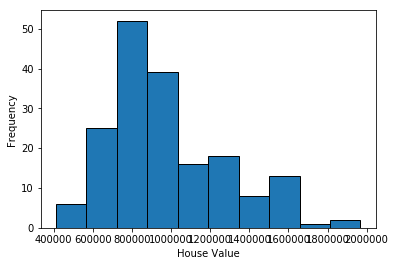

In [12]:
Zestimate([91502
           


In [ ]:
# Common Error - if there is a value error # out of range, rerun the bar code from above
# Print Statements 
# Address Missing Data